In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging
import json
import random

import numpy as np
import json
from tqdm.notebook import tqdm


# Set-up

## Load data

In [2]:
# Load imagenet


# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Get class names
# imagenet_class_nums = np.arange(0, 1000, 1)
# imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]

# Set the seed. You don't need indices if data is loaded in same order every time.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# # Load the ImageNet dataset
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)


# Patch/image-level analysis for maximally activating neurons

Look at maximally activating neurons with patch/image as the individual unit.

Loaded from precached activations from 500 randomly sampled ImageNet points.

In [3]:
import pandas as pd
import os

layer_num = 9

save_path = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/'
file_name = f'mlp_fc1_{layer_num}.npz'

loaded = pd.read_parquet(os.path.join(save_path, file_name))


### Get standard deviation of patch value 

On the neuron level (aggregating across all images and patches for that neuron)**

In [4]:
# Calculate mean and standard deviation for 'activation_value' grouped by 'neuron_idx'
grouped = loaded.groupby('neuron_idx')['activation_value']
mean_per_neuron = grouped.transform('mean')
std_dev_per_neuron = grouped.transform('std')

# Calculate the z-score (number of standard deviations from the mean)
loaded['activation_value_sds'] = (loaded['activation_value'] - mean_per_neuron) / std_dev_per_neuron

# Replace NaN and infinite values (which can occur if std_dev is zero) with zero
loaded['activation_value_sds'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)


# Sort by z-score
sorted_df = loaded.sort_values(by=['activation_value_sds'], ascending=False)

In [5]:
sorted_df.head(10).style.background_gradient("coolwarm")

In [6]:
sorted_df.tail(10).style.background_gradient("coolwarm")

In [7]:
# Ensure 'neuron_idx' is not part of the index
top_patches_per_neuron = loaded.reset_index(drop=True)

# Group by 'neuron_idx', then sort within groups by 'activation_value'
grouped = top_patches_per_neuron.groupby('neuron_idx', group_keys=False).apply(lambda x: x.sort_values('activation_value_sds', ascending=False))

# Get top 5 entries for each neuron
top_5_per_neuron = grouped.groupby('neuron_idx').head(5)

# Selecting the relevant columns
top_5_per_neuron = top_5_per_neuron[['batch_idx', 'neuron_idx', 'patch_idx', 'class_name', 'predicted', 'activation_value', 'activation_value_sds']]

top_5_per_neuron.to_csv(f'top_5_per_neuron_layer_{layer_num}.csv', index=False)

In [8]:
top_5_per_neuron.head(10).style.background_gradient("coolwarm")

# Sort by z-score
top_5_sorted_df = top_5_per_neuron.sort_values(by=['activation_value_sds'], ascending=False)

In [9]:
top_5_sorted_df.head(20).style.background_gradient("coolwarm")


### Visualize heatmap for specific image + neuron

In [10]:
import pandas as pd


def plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224, pixel_num=14):

    activation_values_array = activation_values_array.reshape(pixel_num, pixel_num)

    # Create a heatmap overlay
    heatmap = np.zeros((image_size, image_size))
    patch_size = image_size // pixel_num

    for i in range(pixel_num):
        for j in range(pixel_num):
            heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = activation_values_array[i, j]

    # Plotting the image with the heatmap overlay
    fig, ax = plt.subplots()
    ax.imshow(image.permute(1,2,0))
    ax.imshow(heatmap, cmap='viridis', alpha=0.6)  # Overlaying the heatmap

    # Removing axes
    ax.axis('off')

    min_activation = activation_values_array.min()
    max_activation = activation_values_array.max()

    # Adding colorbar for the heatmap
    plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_activation, vmax=max_activation)), ax=ax, orientation='vertical')

    plt.title("Neuron {}'s Activation Values for Image {}".format(specific_neuron_idx, ""))
    plt.show()




In [11]:
def get_image_and_activations_by_id(specific_neuron_idx, specific_image_idx):
    image, label = load_specific_image(imagenet_data, random_indices, specific_image_idx)

    filtered_df = loaded[(loaded['batch_idx'] == specific_image_idx) & 
                                (loaded['neuron_idx'] == specific_neuron_idx)]

    activation_values = filtered_df['activation_value_sds']

    activation_values_array = activation_values.to_numpy()[1:]

    return image, activation_values_array


# Load saved indices
random_indices = np.load('../imagenet_sample_indices.npy')

# Function to load a specific image
def load_specific_image(dataset, indices, order):
    specific_index = indices[order]  # Subtract 1 because list indices start at 0
    image, label = dataset[specific_index]
    return image, label


          batch_idx               class_name             predicted  patch_idx  \
93725141        464                 komondor    Bedlington_terrier        120   
25461205        126               white_wolf            Arctic_fox         42   
30311893        150                 snowplow              snowplow         51   
31646165        156                 ice_bear            Arctic_fox        172   
8163797          40                stretcher                 rifle         92   
91187669        452                    cloak                 cloak          6   
8511957          42  wire-haired_fox_terrier       giant_schnauzer         38   
85428693        423                   cannon                 patio         95   
76545493        379                  clumber    Bedlington_terrier         88   
77444565        383                    junco                 junco        178   
80136661        397               chimpanzee               gorilla         49   
93481429        463         

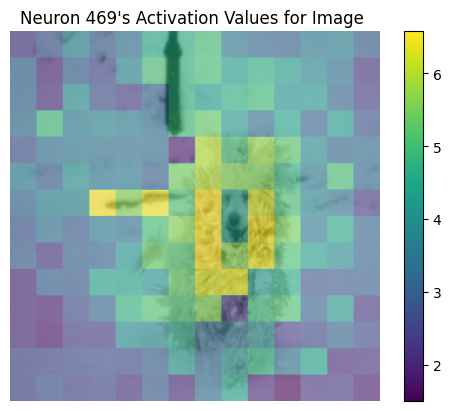

Class Name: komondor
Activation Value: 4.859940528869629
Batch Index: 464



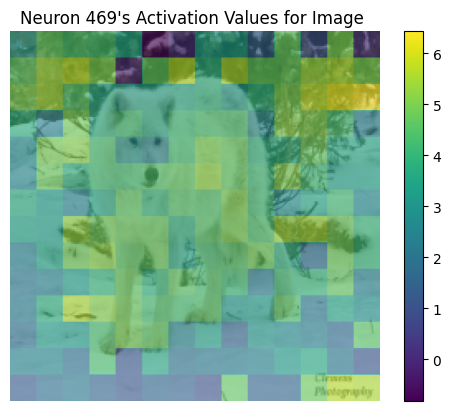

Class Name: white_wolf
Activation Value: 4.671438217163086
Batch Index: 126



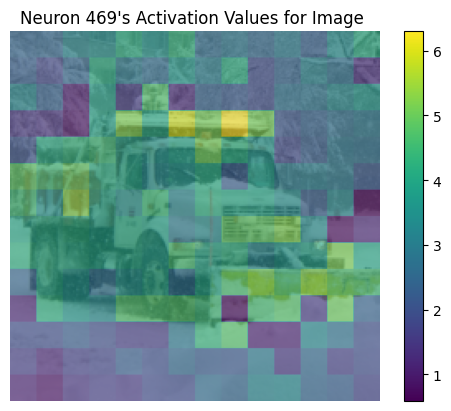

Class Name: snowplow
Activation Value: 4.5089569091796875
Batch Index: 150



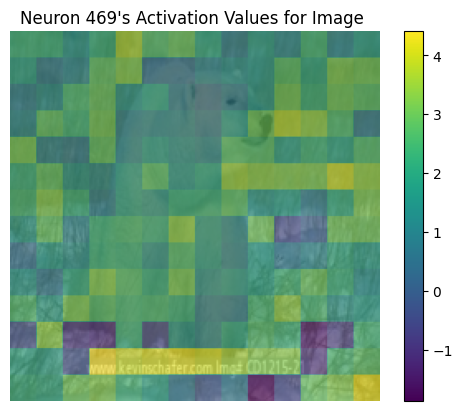

Class Name: ice_bear
Activation Value: 2.1557211875915527
Batch Index: 156



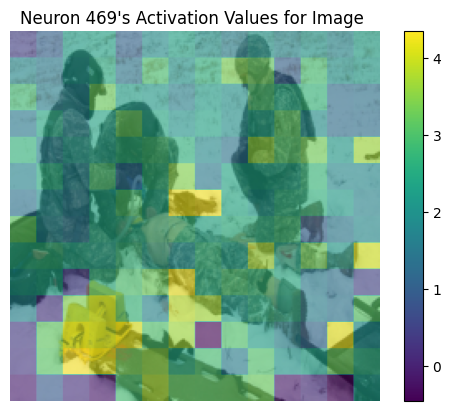

Class Name: stretcher
Activation Value: 2.084549903869629
Batch Index: 40



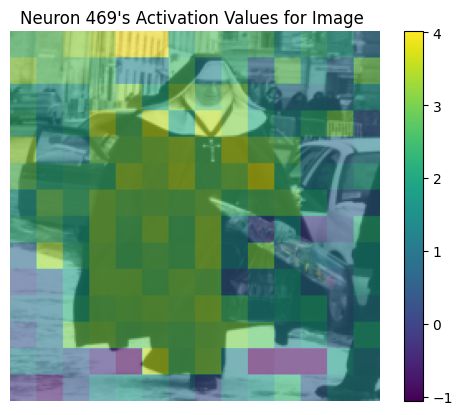

Class Name: cloak
Activation Value: 1.6728577613830566
Batch Index: 452



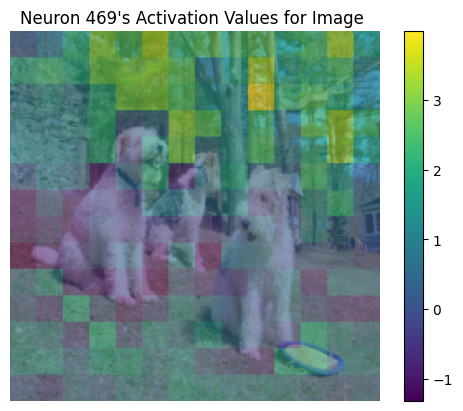

Class Name: wire-haired_fox_terrier
Activation Value: 1.6377308368682861
Batch Index: 42



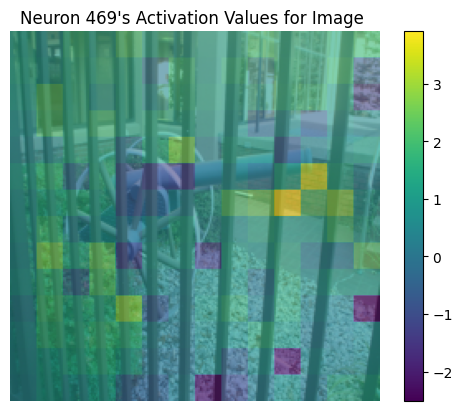

Class Name: cannon
Activation Value: 1.5465264320373535
Batch Index: 423



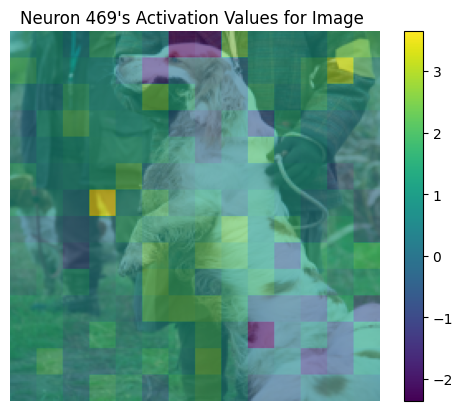

Class Name: clumber
Activation Value: 1.2151505947113037
Batch Index: 379



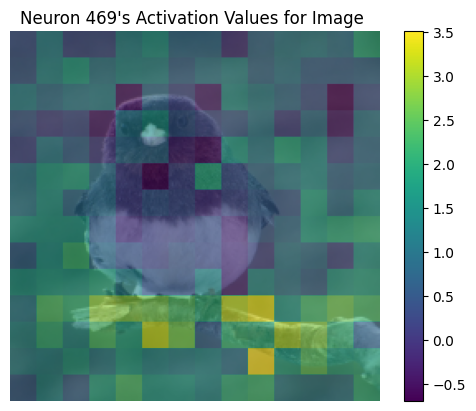

Class Name: junco
Activation Value: 1.0407493114471436
Batch Index: 383



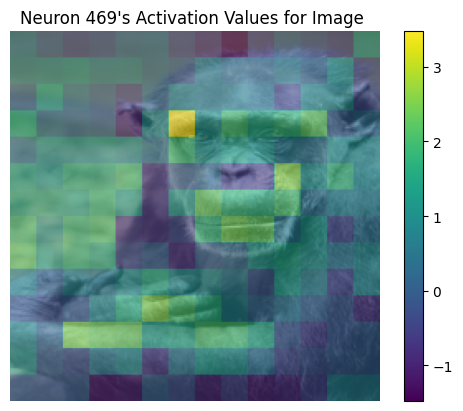

Class Name: chimpanzee
Activation Value: 1.0035157203674316
Batch Index: 397



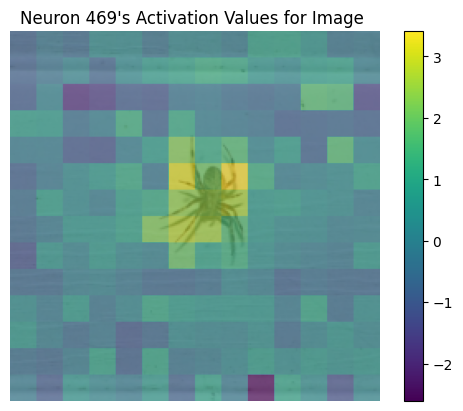

Class Name: barn_spider
Activation Value: 0.9132004380226135
Batch Index: 463



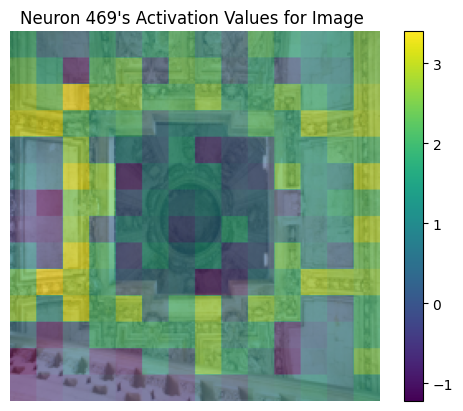

Class Name: vault
Activation Value: 0.9102401733398438
Batch Index: 416



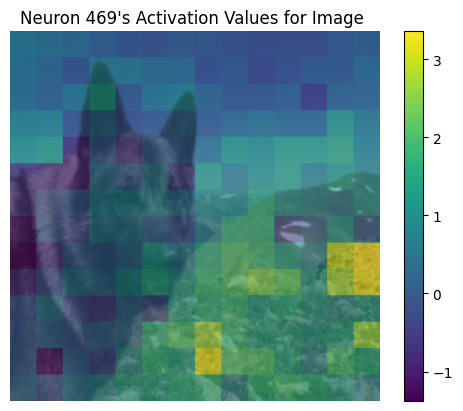

Class Name: Norwegian_elkhound
Activation Value: 0.8549226522445679
Batch Index: 182



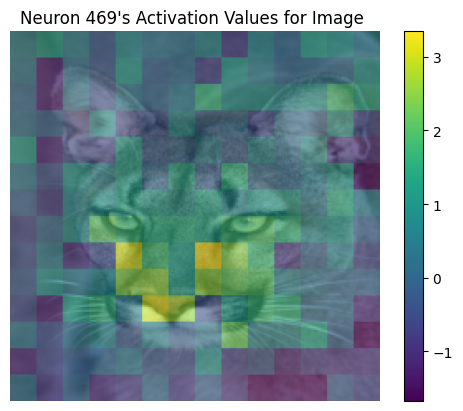

Class Name: cougar
Activation Value: 0.8424292206764221
Batch Index: 265



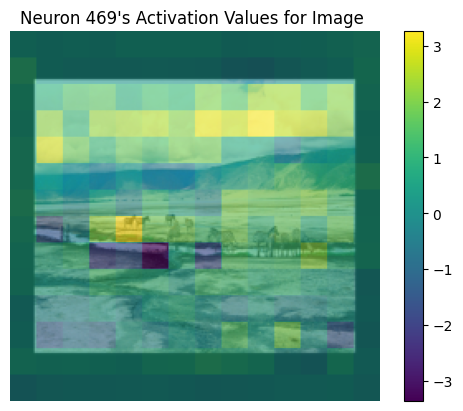

Class Name: zebra
Activation Value: 0.7316820621490479
Batch Index: 181



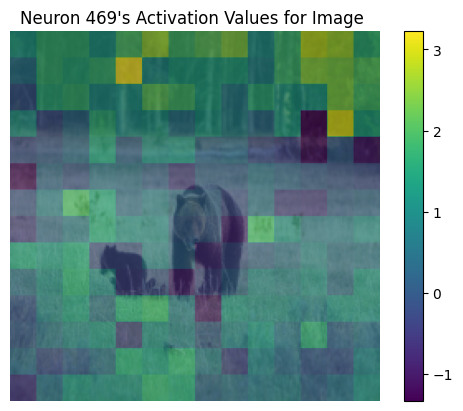

Class Name: brown_bear
Activation Value: 0.6913354396820068
Batch Index: 342



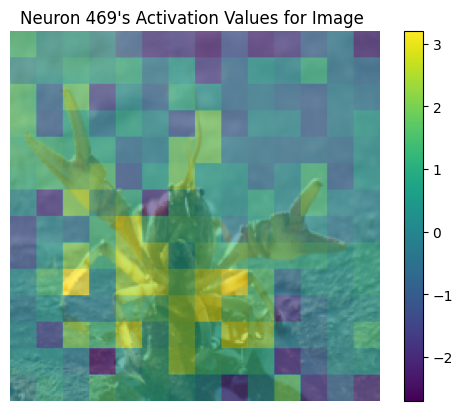

Class Name: crayfish
Activation Value: 0.661450207233429
Batch Index: 147



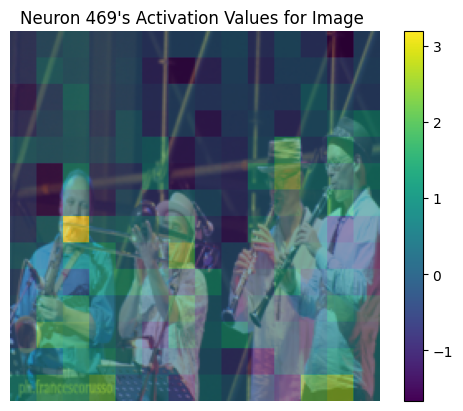

Class Name: sax
Activation Value: 0.6503342986106873
Batch Index: 117



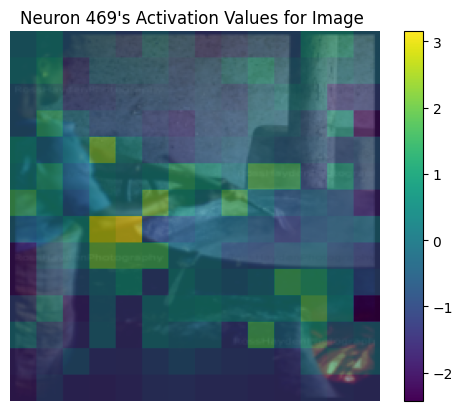

Class Name: caldron
Activation Value: 0.601957380771637
Batch Index: 306



In [12]:
# Get top 10 class names, no duplicates
import matplotlib.pyplot as plt

specific_neuron_idx = 469

unique_top_entries = sorted_df[sorted_df['neuron_idx'] == specific_neuron_idx].drop_duplicates(subset='class_name').head(20)
print(unique_top_entries)
# Extracting class names and activation values
unique_top_class_names = unique_top_entries['class_name'].tolist()
unique_top_activations = unique_top_entries['activation_value'].tolist()
unique_top_batch_idx = unique_top_entries['batch_idx'].tolist()

# Lists are ready to use
print("Top 10 Unique Class Names:", unique_top_class_names)
print("Corresponding Activations:", unique_top_activations)
print("Corresponding Batch Indices:", unique_top_batch_idx)


for i, batch_idx in enumerate(unique_top_batch_idx):
    image, activation_values_array = get_image_and_activations_by_id(specific_neuron_idx, batch_idx)
    plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224)
    print("Class Name:", unique_top_class_names[i])
    print("Activation Value:", unique_top_activations[i])
    print("Batch Index:", unique_top_batch_idx[i])
    print("")
# image, activation_values_array = get_image_and_activations_by_id(specific_neuron_idx, unique_top_batch_idx[0])
# plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224)

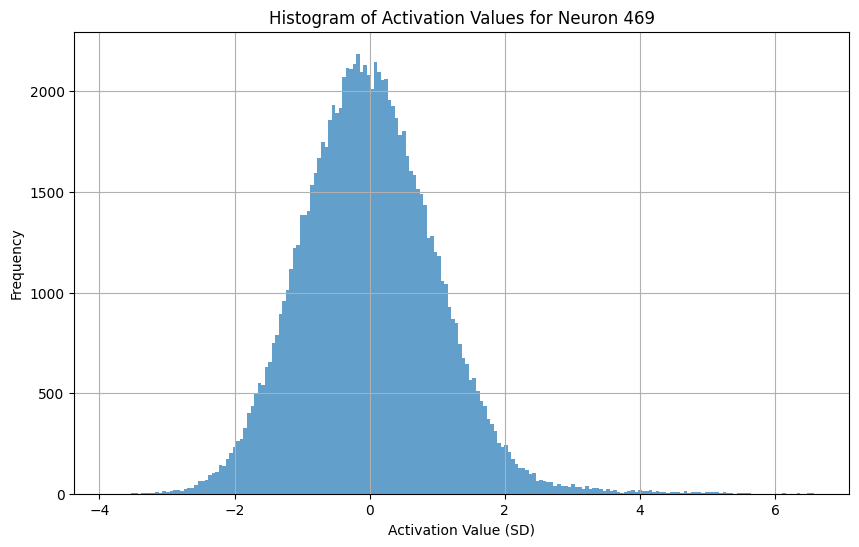

In [13]:
import pandas as pd
import matplotlib.pyplot as plt


# Should this be in log scale?



# Filter the DataFrame to only include the neuron of interest
filtered_df = loaded[loaded['neuron_idx'] == specific_neuron_idx]

# Create a histogram of the activation values
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['activation_value_sds'], bins=200, alpha=0.7)
plt.title(f'Histogram of Activation Values for Neuron {specific_neuron_idx}')
plt.xlabel('Activation Value (SD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Do this in log scale? 
